## Intro
In this example we estimate the number of photons needed to be detected to achieve a singal-to-noise ratio of 1 givne certain observation parameters. To do so, we use the simplest optical model of an interferometer with a densified combiner, and assume that the baselines are perfectly known. Under these extremely optimistic assumptions, we obtain the linear sensitivity of the interferometer to photon flux from differenet elements on the surface of a hypothetical star. This sensitivy matrix is then used to find the total required number pf photons throughout the observation.

## Optics
In out very simplified model, the densified pupil consists of 9 circular sub-apertures, each sees a different phase depnding on its position and the direction of the starlight. A 2D Fourier transform is then used to produce the images.
### Sub-apertures
The circular apertures are approximated by 16x16 binary masks on a 1024x1024 pupil. Note that this limits that positioning accuracy of the masks to within one pupil pixel.

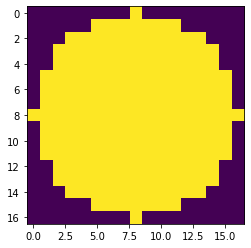

In [14]:
import numpy as np
import matplotlib.pyplot as plt

P_pupil = 1024 #pixels across pupil plane
DB = 128 #densified baseline in pixels
MD = 16 #mirror diameter in pixels

#sub-aperture mask
sub_mask = (np.arange(-MD//2,MD//2+1).reshape((-1,1))**2 + np.arange(-MD//2,MD//2+1).reshape((1,-1))**2 <= MD**2//4).astype(int)
plt.imshow(sub_mask)

### Pupil plane
The pupil-plane electric field is non-zero at the sub-apertures. Each sub-aperture has a different uniform phase depending on its location and on the direction of light from the star.

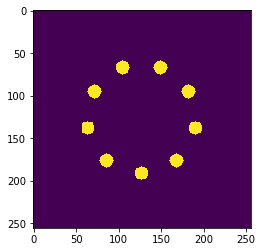

In [38]:
def pupil_phase(n_mirrors, densified_baseline, mirrors_rotation, alpha, beta):
    P = np.zeros((P_pupil, P_pupil), dtype=complex)
    #iterate over mirrors and compute their position on a circle
    for theta in np.arange(n_mirrors)*(2*np.pi/n_mirrors) + mirrors_rotation:
        i_from = int(P_pupil/2 - sub_mask.shape[0]/2 + densified_baseline/2*np.cos(theta))
        j_from = int(P_pupil/2 - sub_mask.shape[1]/2 + densified_baseline/2*np.sin(theta))

        phase = np.cos(theta)*alpha + np.sin(theta)*beta #the phase of the light from resles (alpha, beta) at the mirror due to OPD
        P[i_from:i_from+sub_mask.shape[0],j_from:j_from+sub_mask.shape[1]] = sub_mask*complex(np.cos(phase), np.sin(phase))
        
    return P

P = pupil_phase(9,DB,0,0,0)#an example
plt.imshow(P[P_pupil//2-DB:P_pupil//2+DB,P_pupil//2-DB:P_pupil//2+DB].real)

### Image plane
In this simple model the image-plaen electric field is a Fourier transfrom of the pupil plane.

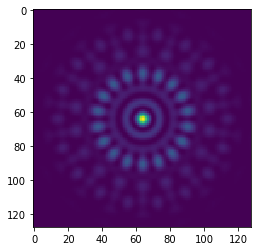

In [39]:
def image_intensity(n_mirrors, densified_baseline, mirrors_rotation, alpha, beta):
    P = pupil_phase(n_mirrors, densified_baseline, mirrors_rotation, alpha, beta)
    E = np.fft.fftshift(np.fft.fft2(P))
    return (E*E.conj()).real

I = image_intensity(9,DB,0,0,0)#an example
plt.imshow(I[P_pupil//2-P_pupil//MD:P_pupil//2+P_pupil//MD,P_pupil//2-P_pupil//MD:P_pupil//2+P_pupil//MD])

## SNR Calculation
To estimate the number of photons required for SNR=1, we discretize the star into resolution elements (resels) such that there are $d_e$ elmenets across the star (its diameter). Assuming that the all the baselines throughout the observation are perfectly known, finding the intensity of the star's resels reduces to solving a linear problem. Here we compute the corresponding matrix and use it to estimate the required number of photons.

### Response matrix at a given exposure time
For simplicity, we "adjust" the inteferometer baseline such that the the phase difference between the right- and left-most resels on the surface of the star is $4d_e$ radians. We then compute the intensity vectors $\mathbf{I}(\alpha,\beta,k)$ for each resel from the direction (\alpha,\beta) on the star at exposure $k$. The rotation of the mirrors and the ratio between the current baseline and maximum baseline are given. All the vectors are scaled such that their sum is one (units of one photon per resel) stacked together into a matrix $G_k$.

49


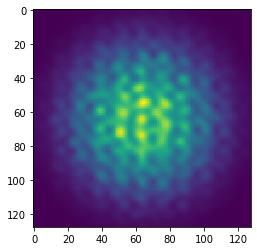

In [40]:
d_e = 2**3+1 #resels across star
star_phase_diameter = 4*d_e #star diameter in radians
n_mirrors = 9 #number of mirrors

def response_matrix(baseline_ratio, mirrors_rotation):
    G_k = []
    #iterate over angular position on the surface od the star
    for alpha in np.linspace(-star_phase_diameter/2, star_phase_diameter/2, d_e):
        for beta in np.linspace(-star_phase_diameter/2, star_phase_diameter/2, d_e):
            if np.hypot(alpha, beta) > star_phase_diameter/2: continue

            #to save space, only store the center of the image
            I = image_intensity(n_mirrors, DB, mirrors_rotation, alpha*baseline_ratio, beta*baseline_ratio)
            sub_I = I[P_pupil//2-P_pupil//MD:P_pupil//2+P_pupil//MD,P_pupil//2-P_pupil//MD:P_pupil//2+P_pupil//MD]
            
            #scale the images, reshape into a vector, and add to the response matrix
            scaled_I = sub_I.ravel()/np.sum(sub_I)
            G_k.append(scaled_I)
            
    return np.array(G_k)

sample_G = response_matrix(1,0) #an exmaple of a response matrix at a given exposure time
N_e = sample_G.shape[0] #number of resels on the surface of the star

sample_detector_image = np.random.random(N_e).dot(sample_G) #random star intensities (science image)
plt.imshow(sample_detector_image.reshape((2*P_pupil//MD,2*P_pupil//MD))) #an example of a detector image

### Photons requirement from full response matrix
Between exposure the mirror rotate in the uv plane and get closer (rotation and baseline ratio change). The full response matrix $G$ would be complied from all the separate matrices $G_k$ at each exposure. However, since the $G$ matrix can get very large, we avoid holding it in memeory. The $G_k$ matrices are scaled by the number of exposures $K$, that way a resel intensity of 1 corresponds to an average of 1 photon received throughout the whole observation from that resel.

Under these assumptions, the number of photons for SNR=1 is given by $\phi_{tot}=
\mathrm{Tr}\left[\left(G^{T}G\right)^{-1}G^{T}\mathrm{diag}\left\{ G\mathbf{\mathbf{1}}\right\} G\left(G^{T}G\right)^{-1}\right]$. We incrmentaly compute the much smaller matrices, $G^TG$ and $G^{T}\mathrm{diag}\left\{ G\mathbf{\mathbf{1}}\right\} G$, to avoid storing the full $G$.

In [41]:
K = 8*d_e #nmber of exposure that seem to be sufficient

#to vaoid storing all response matrices, intiaialize cumulative sums of just he matrices we need for SNR computation
GTG = np.zeros((N_e,N_e))
GT_G_one_G = np.zeros((N_e,N_e))

#iterate over exposures
for k in range(K):
    mirrors_rotation = 2*np.pi*k/K #how much the mirrors are rotated in the uv plane
    baseline_ratio = np.cos((1 - 0.8*k/K)*np.pi/2) #how much the baseline shirnks due to orbital motion of the mirrors
    
    G_k_scaled = response_matrix(baseline_ratio, mirrors_rotation)/K #scaled sub-matrices
    
    #accumulate matrix sums
    GTG += G_k_scaled.dot(G_k_scaled.T)
    GT_G_one_G += (G_k_scaled*np.sum(G_k_scaled, axis=0, keepdims=True)).dot(G_k_scaled.T)

#the total number of photons from star required for SNR=1 which scales vey roughly as the number of resels squared
GTG_inv = np.linalg.inv(GTG)
phi_tot = np.trace(GTG_inv.dot(GT_G_one_G).dot(GTG_inv))
print(phi_tot, N_e**2)

3841.2949584227886 2401
